# Imports:-

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib

# Load data

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Initial EDA

In [3]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Missing values
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [5]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [6]:
# Drop customerID
df.drop('customerID', axis=1, inplace=True)

In [7]:
# Target encoding
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

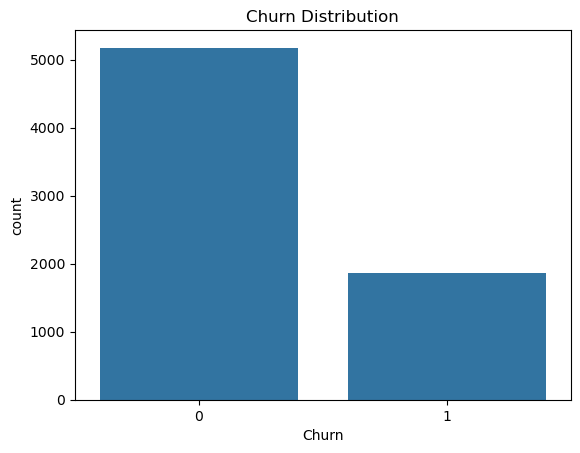

In [8]:
# Basic distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()


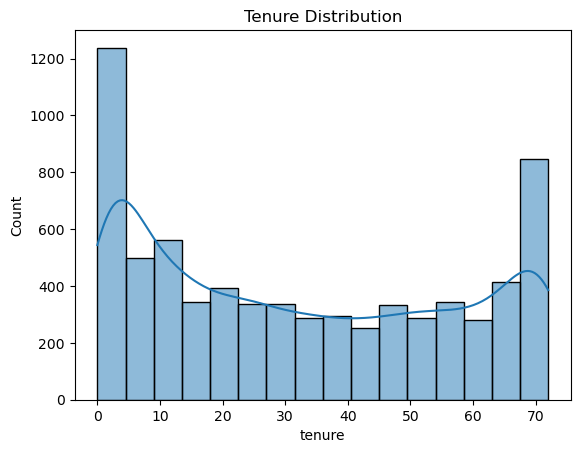

In [9]:
# Distribution of tenure
sns.histplot(df['tenure'], kde=True)
plt.title("Tenure Distribution")
plt.show()

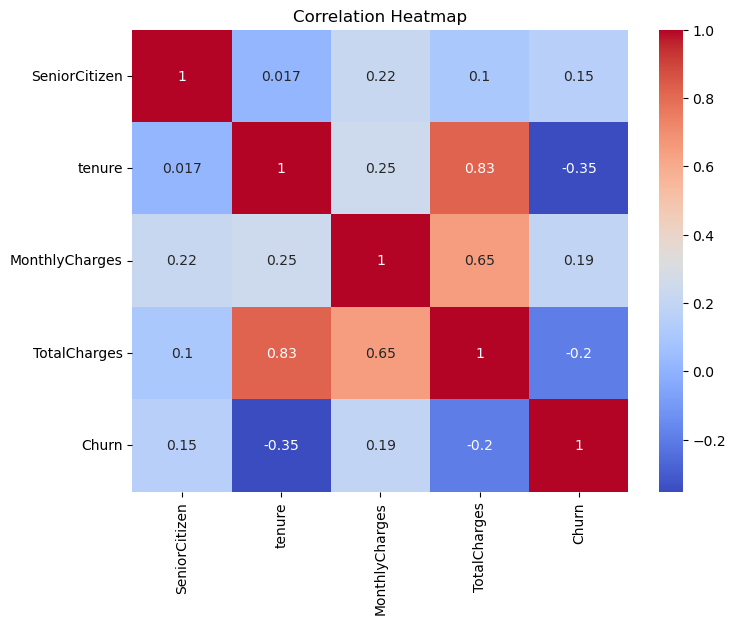

In [11]:
# Select numerical columns only (including target if you want)
num_df = df.select_dtypes(include=['int64', 'float64'])

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


# Handle outliers

In [12]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove('Churn')  # Remove target

def cap_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] > upper, upper,
                       np.where(df[col] < lower, lower, df[col]))

for col in num_cols:
    cap_outliers(col)

# Columns

In [13]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


# Split data

In [14]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipelines

In [ ]:
# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline

In [16]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine

In [17]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Complete pipeline

In [28]:
# New pipeline with Random Forest
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid_rf = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}


# GridSearchCV

In [29]:
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters:", grid_rf.best_params_)
print("Best CV ROC AUC:", grid_rf.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best CV ROC AUC: 0.8476461712964045


# Evaluate

In [30]:
y_pred_rf = grid_rf.predict(X_test)
y_proba_rf = grid_rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba_rf))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1035
           1       0.55      0.75      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409

Confusion Matrix:
 [[802 233]
 [ 93 281]]
Test ROC AUC: 0.840768296778527


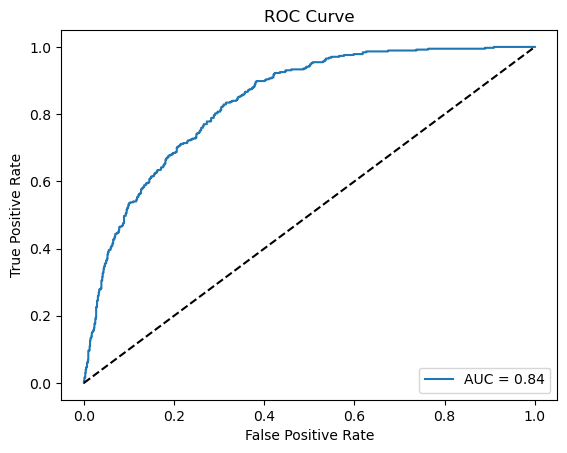

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.show()

# Feature importance

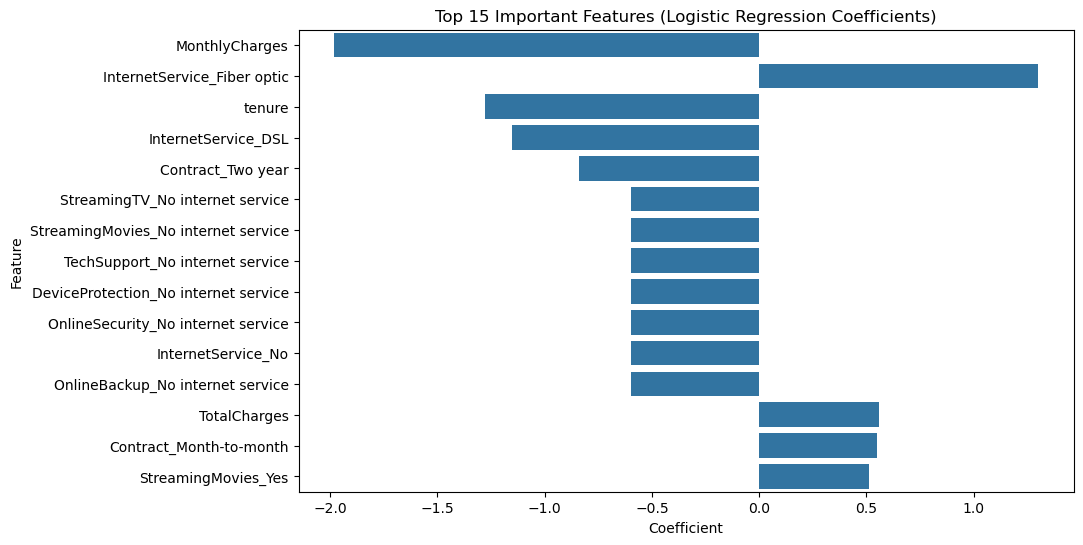

In [32]:
# Get final model
final_model = grid.best_estimator_

# Get feature names after encoding
ohe = final_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, ohe_features])

coefficients = final_model.named_steps['classifier'].coef_[0]

# Create dataframe
feature_importance = pd.DataFrame({'Feature': all_features, 'Coefficient': coefficients})
feature_importance['abs_coeff'] = feature_importance['Coefficient'].abs()
feature_importance.sort_values(by='abs_coeff', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15))
plt.title("Top 15 Important Features (Logistic Regression Coefficients)")
plt.show()